In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
with_call = 'data/train_data/spec/1'
without_call = 'data/train_data/spec/0'

paths_with_call = [join(with_call, f) for f in listdir(with_call) if isfile(join(with_call, f))]
paths_without_call = [join(without_call, f) for f in listdir(without_call) if isfile(join(without_call, f))]

- (b) View Batch

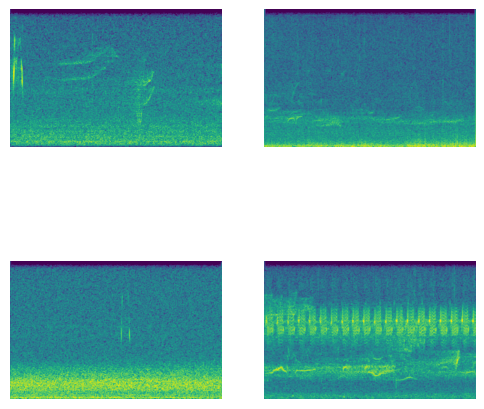

In [4]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_with_call[np.random.randint(len(paths_with_call))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_without_call[np.random.randint(len(paths_without_call))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_with_call[np.random.randint(len(paths_with_call))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_without_call[np.random.randint(len(paths_without_call))]));

## B - <a name="generateurs"></a> Générateurs

- (c) Définir trois générateurs :
> - ```train_data_generator``` avec les paramètres de transformation de votre choix (on prendra un ```validation_split``` de 0.2 et un scaling de 1/255)
>
> - ```valid_data_generator``` avec un ```validation_split``` de 0.2 et un scaling de 1/255
>
> - ```test_data_generator``` avec un scaling de 1/255

In [5]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implémenter sous les noms ```training_data```, ```valid_data``` 
> - On choisira une taille cible de (224, 224) (pour le ```VGG16```), une classe binaire (avec ou sans masque), et des lots de données de taille 32 (pour train et valid) ou 1 (pour test).

In [6]:
training_data  = train_data_generator.flow_from_directory(directory = 'data/train_data/spec',
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = 32)

validation_data  = train_data_generator.flow_from_directory(directory = 'data/train_data/spec',
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = 32)

test_data  = test_data_generator.flow_from_directory(directory = 'data/train_data/spec',
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   batch_size = 32)


Found 2250 images belonging to 2 classes.
Found 561 images belonging to 2 classes.
Found 2811 images belonging to 2 classes.


In [7]:
x_batch, y_batch = next(training_data)

# The first image in the batch will be x_batch[0]
first_image = x_batch[0]

# Get the shape of the first image
print("Shape of the first image:", first_image.shape)

Shape of the first image: (224, 224, 3)


# II - <a name="classif"></a> Classification

- (a) Importer le modèle ```VGG16``` et freezer ses couches.

- (b) Instancier un réseau de neurones (appelé ```model```), lui ajouter le modèle ```VGG16``` et ajouter les couches denses de votre choix.

- (c) Compiler le modèle avec une métrique appropriée.

- (d) Entraîner le modèle avec les paramètres de votre choix. On pourra également définir des callbacks.

- (e) Evaluer le modèle sur les données de test avec la méthode ```evaluate```.

In [8]:
# Modèle VGG16
#base_model = VGG16(weights='imagenet', include_top=False)
base_model = MobileNet(weights='imagenet', include_top=False)

# Freezer les couches du VGG16
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\dgnhk\AppData\Local\Temp\ipykernel_5388\2462421750.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)


In [9]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 4,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience=3,
                                         factor=0.5,
                                         verbose=2,
                                         mode='min',
                                         min_lr = 1e-10)

In [10]:
optimizer = Adam(learning_rate=0.0001) 

In [11]:
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
history = model.fit(training_data, validation_data=validation_data, epochs=50, callbacks=[early_stopping,lr_plateau])

Epoch 1/50


c:\Users\dgnhk\anaconda3\envs\yevhenii\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.6846 - loss: 0.6299 - val_accuracy: 0.7130 - val_loss: 0.6163 - learning_rate: 1.0000e-04
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 432ms/step - accuracy: 0.7055 - loss: 0.6073 - val_accuracy: 0.7398 - val_loss: 0.5776 - learning_rate: 1.0000e-04
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 46s 635ms/step - accuracy: 0.7219 - loss: 0.5710 - val_accuracy: 0.7701 - val_loss: 0.5434 - learning_rate: 1.0000e-04
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 23s 300ms/step - accuracy: 0.7280 - loss: 0.5763 - val_accuracy: 0.7879 - val_loss: 0.5227 - learning_rate: 1.0000e-04
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 227ms/step - accuracy: 0.7645 - loss: 0.5267 - val_accuracy: 0.7950 - val_loss: 0.5055 - learning_rate: 1.0000e-04
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - accuracy: 0.7527 - loss: 0.5327 - val_accuracy: 0.8004 - val_loss: 0.4990 - learning_rate: 1.0000e-04
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - accuracy: 0.75

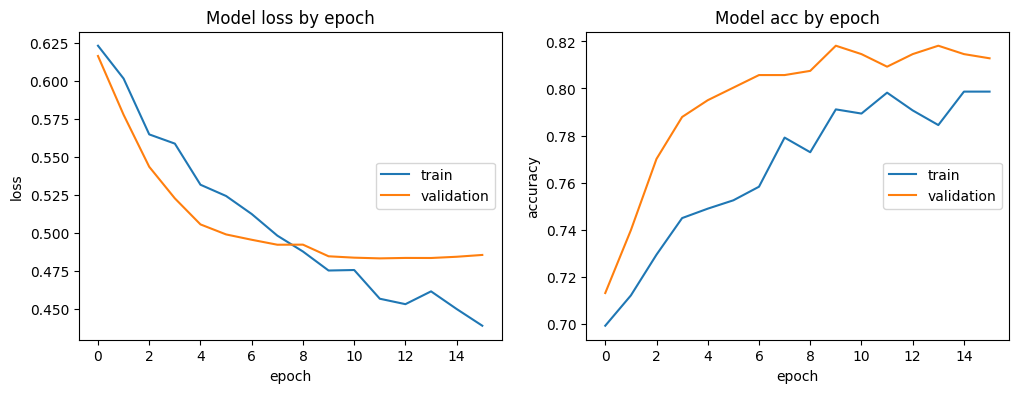

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [14]:
model.save('my_model_epochs20.h5')